In [2]:
import simpy
import random
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd

In [3]:
def hyperexponential():
    """Generates random number between 0 and 1 from hyperexponential distribution"""
    while True:
        random_number = random.random()  
        
        if random_number < 0.75:
            # generate from exp with rate=1 with probability 0.75
            return random.expovariate(1)
        else:
            # generate from exp with rate=1/5 with probability 0.25
            return random.expovariate(1/5)
    

# Queue 

In [4]:
class queue:
    """A queue process. Generates a list with waiting times."""
    def __init__(self, env, arrival_rate, service_rate, num_servers, service_distribution):
        self.env = env
        self.server = simpy.Resource(env, num_servers)
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.waiting_time_in_the_queue=[]
        self.service_distribution = service_distribution
        

    def arrival(self):
        """The arrival process generates customers according to a Poisson process"""
        while True:
            ### Interarrival times follow exponential
            next_customer= random.expovariate(self.arrival_rate)
            ### Wait for the customer
            yield self.env.timeout(next_customer)  
            
            ### Start a service process
            self.env.process(self.service())

    def service(self):
        """The service process. The customer arrives and requests a service. The service time is drawn from a 
           specified distribution"""
        with self.server.request() as req:
            queue_arrival_time= self.env.now
            yield req
            #### calculate waiting time
            waiting_time = self.env.now - queue_arrival_time
            
            if self.service_distribution == "exp":
                service_time = random.expovariate(self.service_rate)
            if self.service_distribution == "hyperexp":
                generated_number = hyperexponential()
                service_time = generated_number
            if self.service_distribution == "det":
                service_time = 1
            
            yield self.env.timeout(service_time)
            
            self.waiting_time_in_the_queue.append(waiting_time)

# Compute waiting time theoretically

In [5]:
def summation(n, rho):
    result = 0

    for i in range(n):
        S = (((n * rho) ** i) / math.factorial(i))

        result += S
        
    return result

def delay_probability(n, rho):
    pi = (((n * rho)**n)/math.factorial(n))*(1/(((1-rho)*summation(n, rho)) + ((n * rho) ** n)/ math.factorial(n)))
    return pi

def theory_waiting_time(n, rho, mu):
    W = delay_probability(n, rho)* (1/(1 - rho))*(1/n*mu)
    return W

rho_waiting_times = {}
rho_values = [0.4, 0.7, 0.9, 0.95]

waiting_time_list = []
for rho in rho_values:
    waiting_time_list.append(theory_waiting_time(1, rho, 1))
print(waiting_time_list)


[0.6666666666666667, 2.333333333333333, 9.000000000000002, 18.999999999999982]


# Simulate M/M/1 and plot mean waiting time and CI radius across the simulation duration

AttributeError: 'Axes' object has no attribute 'savefig'

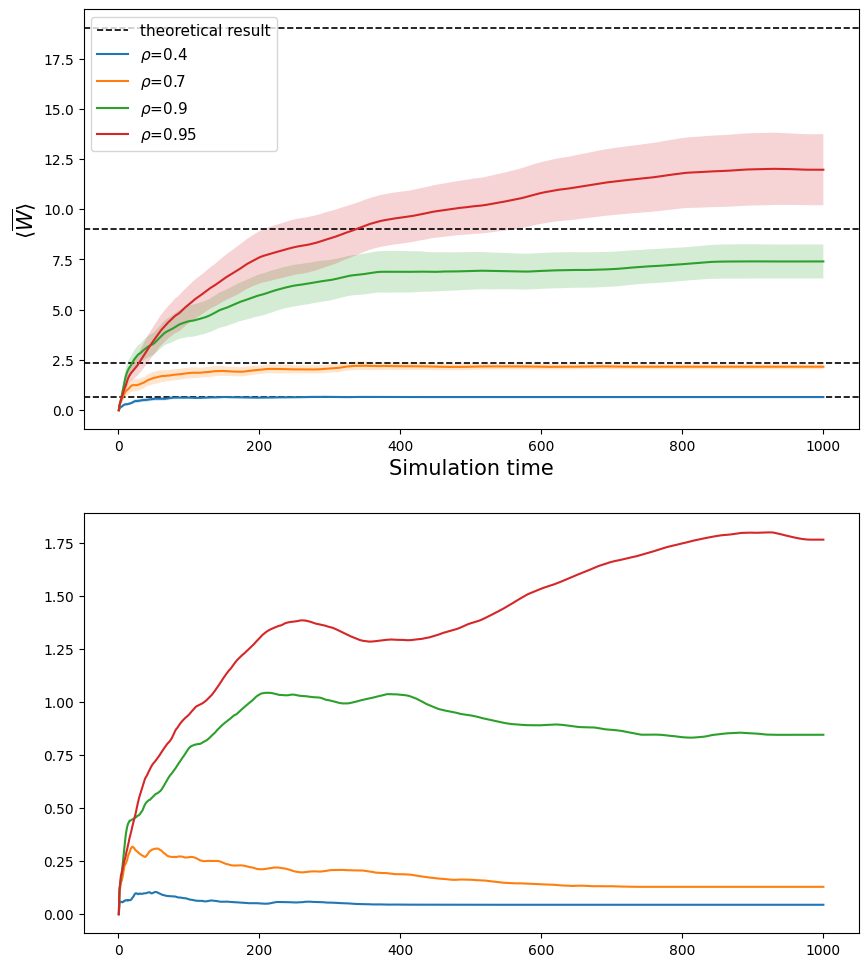

In [7]:
def setup_to_plot(arrival_rate, service_rate, sim_time, num_simulations, num_servers, service_distribution):
    """Setup, simulates and generates mean waiting time and its standard deviation"""
    all_means_waiting_time= []
    
    for i in range(num_simulations):
        
        env = simpy.Environment()
        my_queue = queue(env, arrival_rate, service_rate, num_servers, service_distribution)
        env.process(my_queue.arrival())
        env.run(until=sim_time)
        
        means = []  # collect means for one silmulation across sim_time
        
        for i in range(1, sim_time + 1):
            subset_data=my_queue.waiting_time_in_the_queue[:i]
            mean = np.mean(subset_data)
            means.append(mean)            
            
        all_means_waiting_time.append(means)

    return np.mean(all_means_waiting_time, axis=0), np.std(all_means_waiting_time, axis=0)

#parameters
simulation_time = 1000
num_servers= 1
num_simulations = 50
service_rate =1   # keep service rate the same, but vary arrival rate to get range of rho values


### Plot for different rho values
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
label_added = False 
for arrival_rate in [0.4, 0.7, 0.9, 0.95]:
    means, st_devs= setup_to_plot(arrival_rate, service_rate, simulation_time, num_simulations, num_servers, service_distribution ="exp")
    margin_error = [1.96 * i / np.sqrt(num_simulations) for i in st_devs]
    
    ### plot waiting time according to the theory 
    if not label_added:
        ax1.axhline(y=theory_waiting_time(num_servers, arrival_rate, service_rate), color='k', linestyle='--', linewidth=1.2, label='theoretical result')
        label_added = True  
    else:
        ax1.axhline(y=theory_waiting_time(1, arrival_rate, 1), color='k', linestyle='--', linewidth=1.2)
    ### plot mean waiting time according to the simulations
    ax1.plot(range(1, simulation_time +1), means, label=r'$\rho$=' + f'{arrival_rate}')
    ax1.fill_between(range(1, simulation_time +1), means+margin_error, means-margin_error, alpha=0.2)

    ### plot CI radius
    ax2.plot(range(1, simulation_time +1), margin_error, label=r'$\rho$=' + f'{arrival_rate}')

ax1.set_ylabel(r'$\langle \overline{W} \rangle$', fontsize=15)
ax1.set_xlabel("Simulation time", fontsize=15)
ax1.legend(loc='upper left', fontsize=11)
ax1.savefig('plots/W_sim_time.png', dpi=300)

ax2.set_ylabel('CI radius', fontsize=15)
ax2.set_xlabel("Simulation time", fontsize=15)
ax2.legend(loc='upper left', fontsize=11)

#plt.savefig('plots/CI_radius_sim_time.png', dpi=300)

plt.tight_layout()
plt.show()


# Simulate M/M/n (n=1, 2, 4) and plot mean waiting time and CI radius for different rho values

Theoretical result

In [11]:
def theoretical_result_for_rhos(n):
    w_list = []
    for rho in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
        w=theory_waiting_time(n, rho, 1)
        w_list.append(w)
    return w_list

Simulation

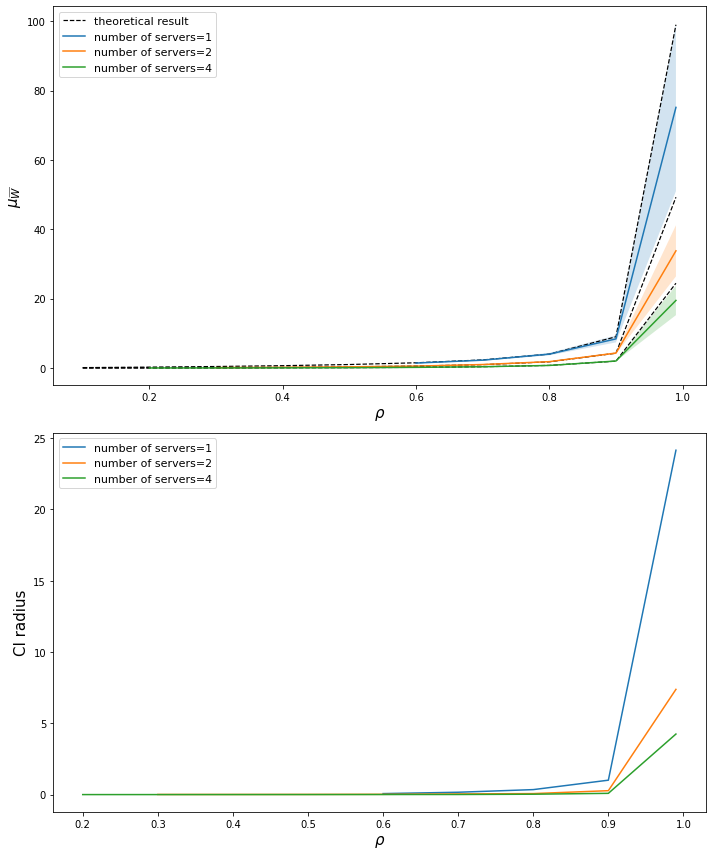

In [13]:
def setup_and_simulate(arrival_rate, service_rate, sim_time, num_simulations, num_servers, service_distribution):
    """Setup, simulates and returns mean waiting times from record =5000"""
    means = []  
    for i in range(num_simulations):

            env = simpy.Environment()
            my_queue = queue(env, arrival_rate, service_rate, num_servers, service_distribution)
            env.process(my_queue.arrival())
            env.run(until=sim_time)
            waiting_time = my_queue.waiting_time_in_the_queue[5000:]

            means.append(waiting_time)

    mean = [np.mean(lst, axis=0) for lst in means] 
    return mean
    

def different_rhos(service_rate, sim_time, num_simulations, num_servers, service_distribution, rho_list):
    """Simulate for different rho values and returns mean waiting times, mean sample waiting time 
       and its standart deviation"""
    wait_times= []
    
    for arrival_rate in rho_list:
        if num_servers==1:
            simulations = setup_and_simulate(arrival_rate, service_rate, sim_time, num_simulations, num_servers, service_distribution)
            wait_times.append(simulations)
        else:
            simulations = setup_and_simulate(arrival_rate*num_servers, service_rate, sim_time, num_simulations, num_servers, service_distribution)
            wait_times.append(simulations)
            
    mean_wait_times = [np.mean(lst, axis=0) for lst in wait_times] 
    std_dev_wait_times = [np.std(lst, axis=0) for lst in wait_times]
    entire_data = wait_times
    return entire_data, np.array(mean_wait_times), np.array(std_dev_wait_times)

#parameters
simulation_time = 10000
num_simulations = 25
service_rate = 1

### Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
label_added = False 
for i in [1, 2, 4]:
    detailed_rho_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
    data, means, stdev = different_rhos(service_rate, simulation_time, num_simulations, i, service_distribution ="exp", rho_list =detailed_rho_list)
    margin_error = [1.96 * i / np.sqrt(num_simulations) for i in stdev]
    
    ### plot theoretical result
    if not label_added:
        ax1.plot(detailed_rho_list, theoretical_result_for_rhos(i), color='k', linestyle='--', linewidth=1.2, label= "theoretical result")
        label_added = True  
    else:
        ax1.plot(detailed_rho_list, theoretical_result_for_rhos(i), color='k', linestyle='--', linewidth=1.2)
        
    ### plot simulations
    ax1.plot(detailed_rho_list, means, label= r'number of servers=' + f'{i}')
    ax1.fill_between(detailed_rho_list, means+margin_error, means-margin_error, alpha=0.2)
    
    ### plot CI radius
    ax2.plot(detailed_rho_list, margin_error, label= r'number of servers=' + f'{i}')
    
# ax1.set_ylabel(r'$\mu_{ \widebar{W}}$', fontsize=15)
ax1.set_ylabel(r'$\langle \overline{W} \rangle$', fontsize=15)

ax1.set_xlabel(r'$\rho$', fontsize=15)
ax1.legend(fontsize=11)
#ax1.savefig('.png', dpi=300)

ax2.set_ylabel("CI radius", fontsize=15)
ax2.set_xlabel(r'$\rho$', fontsize=15)
ax2.legend(fontsize=11)
#ax2.savefig('.png', dpi=300)

plt.tight_layout()
plt.show()
  

Plot sampling distribution of the sample mean

In [78]:
simulation_time = 10000
num_simulations = 25
service_rate = 1

mm1_09 = different_rhos(service_rate , simulation_time, num_simulations, 1, service_distribution="exp", rho_list=[0.9, 0.99])[0][0]
mm1_099 = different_rhos(service_rate , simulation_time, num_simulations, 1, service_distribution="exp", rho_list=[0.9, 0.99])[0][1]

mm2_09 = different_rhos(service_rate , simulation_time, num_simulations, 2, service_distribution="exp", rho_list=[0.9, 0.99])[0][0]
mm2_099 = different_rhos(service_rate , simulation_time, num_simulations, 2, service_distribution="exp", rho_list=[0.9, 0.99])[0][1]

mm4_09 = different_rhos(service_rate , simulation_time, num_simulations, 4, service_distribution="exp", rho_list=[0.9, 0.99])[0][0]
mm4_099 = different_rhos(service_rate , simulation_time, num_simulations, 4, service_distribution="exp", rho_list=[0.9, 0.99])[0][1]

In [79]:
def normal_pdf(data):
    "Returns modelled x and PDF of the normal distribution from the data"
    mean = np.mean(data)
    std_dev = np.std(data)
    # Define the range for x-values 
    x = np.linspace(mean - 4 * std_dev, mean + 4 * std_dev, 100)
    # Calculate the PDF of the normal distribution
    pdf = (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-(x - mean)**2 / (2 * std_dev**2))
    
    return x, pdf

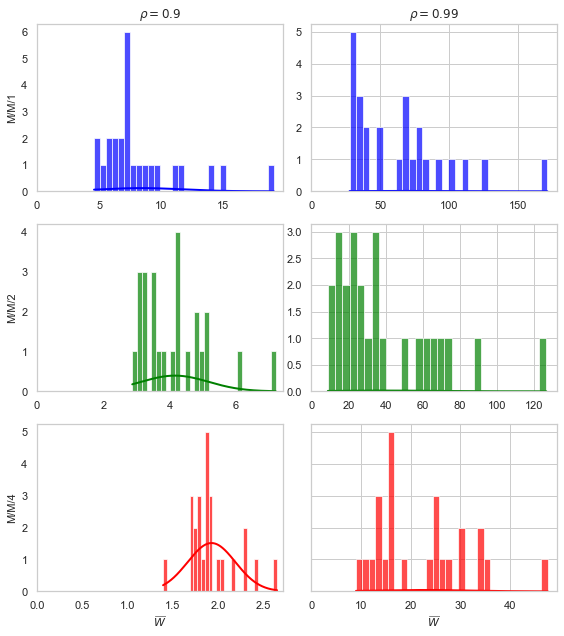

In [132]:
fig, axs = plt.subplots(3, 2, figsize=(8, 9))  
axs[0, 0].hist(mm1_09, bins=30, density=False, alpha=0.7, color='blue')
axs[0, 0].set_title(r'$\rho=0.9$')
axs[0, 0].plot(normal_pdf(mm1_09)[0], normal_pdf(mm1_09)[1], linewidth=2, color='blue')
axs[0, 0].set_xlim(left=0)
axs[0, 1].hist(mm1_099, bins=30, density=False, alpha=0.7, color='blue')
axs[0, 1].set_title(r'$\rho=0.99$')
axs[0, 1].plot(normal_pdf(mm1_099)[0], normal_pdf(mm1_099)[1], linewidth=2, color='blue')
axs[0, 1].set_xlim(left=0)
axs[1, 0].hist(mm2_09, bins=30, density=False, alpha=0.7, color='green')
axs[1, 0].plot(normal_pdf(mm2_09)[0], normal_pdf(mm2_09)[1], linewidth=2, color='green')
axs[1, 0].set_xlim(left=0)
axs[1, 1].hist(mm2_099, bins=30, density=False, alpha=0.7, color='green')
axs[1, 1].plot(normal_pdf(mm2_099)[0], normal_pdf(mm2_099)[1], linewidth=2, color='green')
axs[1, 1].set_xlim(left=0)
axs[2, 0].hist(mm4_09, bins=30, density=False, alpha=0.7, color='red')
axs[2, 0].plot(normal_pdf(mm4_09)[0], normal_pdf(mm4_09)[1], linewidth=2, color='red')
axs[2, 0].set_xlim(left=0)
axs[2, 1].hist(mm4_099, bins=30, density=False, alpha=0.7, color='red')
axs[2, 1].plot(normal_pdf(mm4_099)[0], normal_pdf(mm4_099)[1], linewidth=2, color='red')
axs[2, 1].set_xlim(left=0)

for ax in axs[-1, :]: 
    ax.set_xlabel(r'$\widebar{W}}$', fontsize=11)  
    ax.label_outer()
   
    
y_labels = ['M/M/1', 'M/M/2', 'M/M/4']  
for i, ax in enumerate(axs[:, 0]):  
    ax.set_ylabel(y_labels[i], fontsize=11) 
    
    ax.grid(False)
plt.tight_layout()
plt.show()

# Plot M/M/n, M/H/n, M/D/n

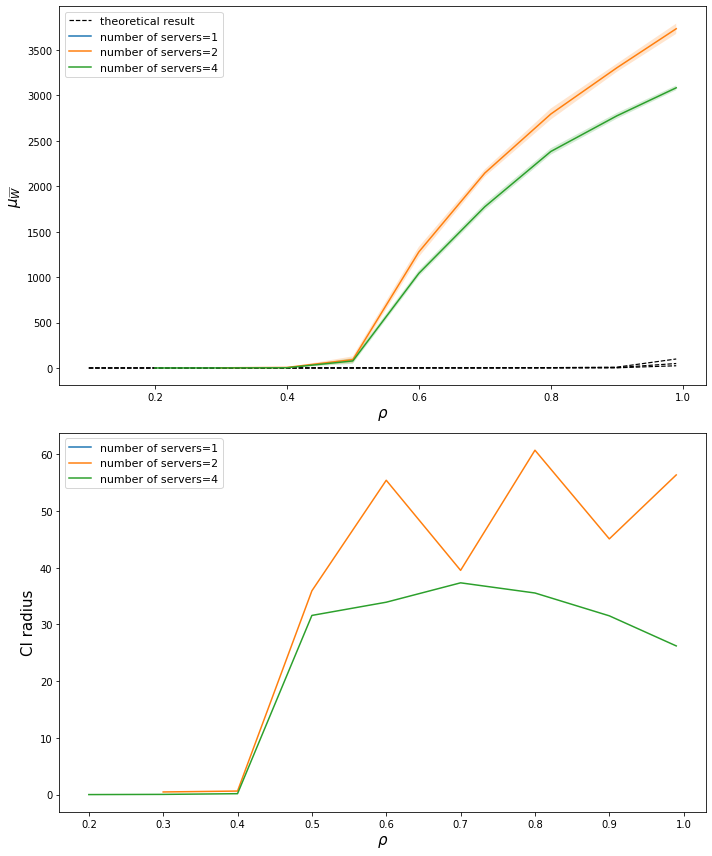

In [88]:
#parameters
simulation_time = 10000
num_simulations = 15
service_rate = 1

### Plotting
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
label_added = False 
for i in [1, 2, 4]:
    detailed_rho_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
    data, means, stdev = different_rhos(service_rate, simulation_time, num_simulations, i, service_distribution ="hyperexp", rho_list =detailed_rho_list)
    margin_error = [1.96 * i / np.sqrt(num_simulations) for i in stdev]
    
    ### plot simulations
    ax1.plot(detailed_rho_list, means, label= r'number of servers=' + f'{i}')
    ax1.fill_between(detailed_rho_list, means+margin_error, means-margin_error, alpha=0.2)
    
    ### plot CI radius
    ax2.plot(detailed_rho_list, margin_error, label= r'number of servers=' + f'{i}')
    
ax1.set_ylabel(r'$\mu_{ \widebar{W}}$', fontsize=15)
ax1.set_xlabel(r'$\rho$', fontsize=15)
ax1.legend(fontsize=11)
#ax1.savefig('.png', dpi=300)

ax2.set_ylabel("CI radius", fontsize=15)
ax2.set_xlabel(r'$\rho$', fontsize=15)
ax2.legend(fontsize=11)
#ax2.savefig('.png', dpi=300)

plt.tight_layout()
plt.show()
  

In [100]:
simulation_time = 10000
num_simulations = 25
service_rate = 1

mh1_09 = different_rhos(service_rate , simulation_time, num_simulations, 1, service_distribution="exp", rho_list=[0.9, 0.99])[0][0]
mh1_099 = different_rhos(service_rate , simulation_time, num_simulations, 1, service_distribution="hyperexp", rho_list=[0.9, 0.99])[0][1]

mh2_09 = different_rhos(service_rate , simulation_time, num_simulations, 2, service_distribution="exp", rho_list=[0.9, 0.99])[0][0]
mh2_099 = different_rhos(service_rate , simulation_time, num_simulations, 2, service_distribution="hyperexp", rho_list=[0.9, 0.99])[0][1]

mh4_09 = different_rhos(service_rate , simulation_time, num_simulations, 4, service_distribution="exp", rho_list=[0.9, 0.99])[0][0]
mh4_099 = different_rhos(service_rate , simulation_time, num_simulations, 4, service_distribution="hyperexp", rho_list=[0.9, 0.99])[0][1]


/Users/aizhanshagadatova/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/aizhanshagadatova/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [101]:
simulation_time = 10000
num_simulations = 25
service_rate = 1

md1_09 = different_rhos(service_rate , simulation_time, num_simulations, 1, service_distribution="exp", rho_list=[0.9, 0.99])[0][0]
md1_099 = different_rhos(service_rate , simulation_time, num_simulations, 1, service_distribution="det", rho_list=[0.9, 0.99])[0][1]

md2_09 = different_rhos(service_rate , simulation_time, num_simulations, 2, service_distribution="exp", rho_list=[0.9, 0.99])[0][0]
md2_099 = different_rhos(service_rate , simulation_time, num_simulations, 2, service_distribution="det", rho_list=[0.9, 0.99])[0][1]

md4_09 = different_rhos(service_rate , simulation_time, num_simulations, 4, service_distribution="exp", rho_list=[0.9, 0.99])[0][0]
md4_099 = different_rhos(service_rate , simulation_time, num_simulations, 4, service_distribution="det", rho_list=[0.9, 0.99])[0][1]


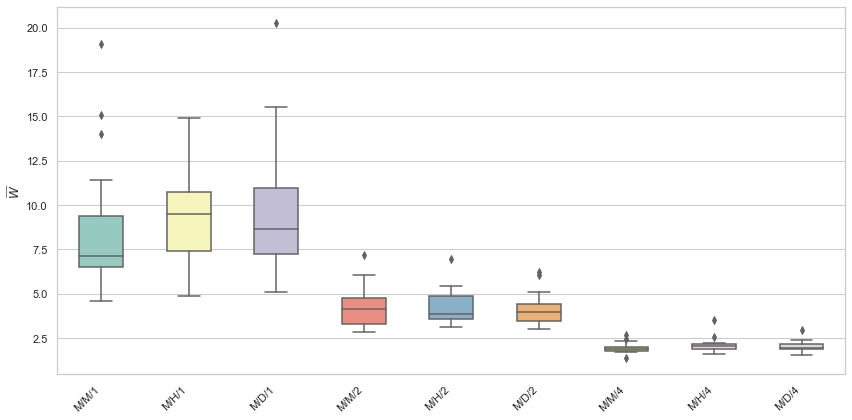

In [133]:
data_sets = [mm1_09, mh1_09, md1_09, mm2_09, mh2_09, md2_09, mm4_09, mh4_09, md4_09]
labels = ['M/M/1', 'M/H/1', 'M/D/1', 'M/M/2', 'M/H/2', 'M/D/2', 'M/M/4', 'M/H/4', 'M/D/4']

plt.figure(figsize=(12, 6))
sns.boxplot(data=data_sets, width=0.5, palette="Set3")
plt.xticks(range(len(data_sets)), labels)  
plt.xticks(rotation=45, ha='right')

plt.ylabel(r'$\widebar{W}}$', fontsize=12)

plt.tight_layout()
plt.show()